In [47]:
using HomotopyContinuation, DynamicPolynomials
using Plots

In [48]:
#generates a random number between -n and n
function genrand(n)
    return rand()*n*2 - n
end

#creates a random polynomial with coeffcients between -n and n and with varsnum number of variables
function get_random_polynomial(varsnum,n)
    @polyvar x[1:varsnum]
    p = genrand(n)
    for i in 1:varsnum
        p += genrand(n) * x[i]^2
        p += genrand(n) * x[i]
        for j in i+1:varsnum
            p += genrand(n) * x[i] * x[j]
        end
    end
    
    return p,x
end

#takes the norm of a polynomial by squarring the coefficients
function get_norm(p)
    normop = norm(MultivariatePolynomials.coefficients(p))
    return normop
end

get_norm (generic function with 1 method)

The function below takes a polynomial "originalpolynomial" and the variables of the polynomial as a list "x"
then it finds the closest polynomial q to the originalpolynomial such that q has a low chow rank

In [49]:
#Just setting a1=1
#can make this faster by computing the alpha*beta only once and keeping it, even the system

function general_function(originalpolynomial, x)
    #setup the starting variables
    numberofa = nvariables(originalpolynomial)
    
    #setup our varibales to create the function to minimise and set a1=1
    @var a[1:numberofa] b[1:numberofa+1]
    
    #get the equations for our function to minimise
    alpha = x[1] + sum([a[i]*x[i+1] for i in 1:numberofa-1]) + a[numberofa]
    beta = sum([b[i]*x[i] for i in 1:numberofa]) + b[numberofa+1]
    p = alpha*beta
    
    #find our a1,...,bn coefficients
    coefsinp = coefficients(p)
    #Get our coeffs from originalpolynomial
    coeffs = MultivariatePolynomials.coefficients(originalpolynomial)
    numberofcoeffs = length(coeffs)
    
    #setup the function to minimise
    mainfunc = sum([(coeffs[i] - (coefsinp[i]))^2 for i in 1:numberofcoeffs])
    
    #get the gradient
    J = differentiate(mainfunc, vcat(a,b)) # vcat(a,b) : concat of vars a and b
    
    #set a system
    system = System(J; variables = vcat(a,b))
    
    #solve the system and get the real solutions
    result = solve(system; show_progress= false)
    real_sols = real_solutions(result; tol=1e-5)
    
    #test if there are results, if not return false
    if real_sols == []
        return false, 0
    end
    
    #find the minimum point using the function that we want to minimize 
    _, minindex = findmin(map(s -> evaluate(mainfunc, a=>s[1:numberofa], b=>s[numberofa+1:(numberofa*2)+1]), real_sols))
    minarg = real_sols[minindex]
    
    #setup the polynomial output
    alphaout = x[1] + sum([x[i+1]*minarg[i] for i in 1:numberofa-1]) + minarg[numberofa]
    betaout = sum([x[i-numberofa]*minarg[i] for i in numberofa+1:(numberofa*2)]) + minarg[(numberofa*2)+1]
    
    return alphaout, betaout
    
end

general_function (generic function with 1 method)

### The function below creates a graph where we the number of loops needed to reach a certain threshold(y) vs
the number of variables in the polynomial(x) <br>
- tolerance : the tolerance that you want to achieve
- maxvars : how man variables does the graph go through, so if maxvars=3 then it will try with 1,2 and 3
- loops : the number of tests with different polynomials for each number of variable
- stop : the number of times the iteration function stopped because it either cant find an answer or had done too many loops (it is set at 40)
- startrange : what should be the range of the coefficients to generate the random polynomial
- allvar : lowers the value of the range as more variables are added

+++++++++++++++Stopped: [0.0, 0.0, 0.0]


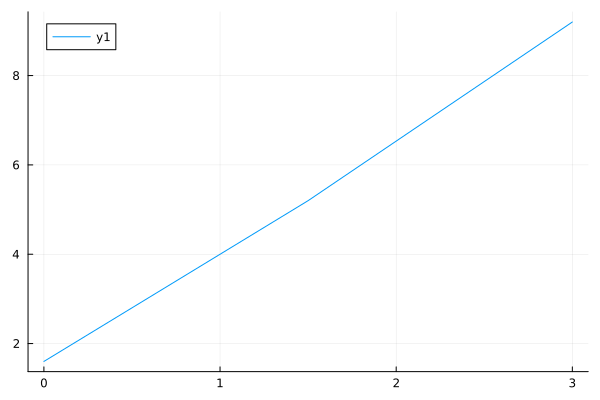

In [50]:
tolerance = 1e-1
maxvars = 3
loops = 5
y = zeros(maxvars)
stop = zeros(maxvars)
startrange = 100
allvar = [startrange-(startrange*i)^.5 for i in 0:maxvars-1]
for numvar in 1:maxvars
    for _ in 1:loops
        #just to show the progression
        print("+")
        p,x = get_random_polynomial(numvar,allvar[numvar])
        polnorm = 10
        iterations = 0
        #while loop that stops only when the desired tolerance is reached
        while polnorm > tolerance
            a,b= general_function(p,x)
            if a == false
                stop[numvar] += 1
                break
            end
            p = p - (a*b)
            iterations += 1
            polnorm = get_norm(p)
            if iterations == 40
                stop[numvar] += 1
                break
            end
        end
        y[numvar] += iterations
    end
end
y = y/loops
println("Stopped: ", stop)
plot(range(0,maxvars,length=maxvars), y)

From this we can see that the more variables are in the start polynomial, the more times we need to loop to get to a certain threshold

### The function below takes a polynomial with a number of variables and outputs: 
- the number of iterations needed get to a certain threshold 
- the time it took in total to reach this threshold and the approximate time it needs per iteration 

The variables have the same meaning as the function on top
- iterations : records the number of iterations needed for each polynomial
- justtime : records the time needed in total to reach the threshold for each polynomial

In [20]:

#needs adjusting
tolerance = 1e-5
maxvars = 3
stop = zeros(maxvars)
iterations = zeros(maxvars)
justtime = zeros(maxvars)
for numvar in 1:maxvars
    p,x = get_random_polynomial(numvar,10)
    polnorm = 10
    t = time()
    while polnorm > tolerance
        a,b= general_function(p,x)
        if a == false
            stop[numvar] += 1
            break
        end
        p = p - (a*b)
        iterations[numvar] += 1
        polnorm = get_norm(p)
        if iterations[numvar] == 40
            stop[numvar] += 1
            break
        end
    end
    justtime[numvar] += time() - t
end

for i in 1:maxvars
    println("Taking a polynomial with ",i," vars: ")
    if stop[i] == 1
        println("It was not able to reach ",tolerance," within ",iterations[i]," iterations.")
    else
        println("Needed to go through ",iterations[i]," iterations taking ",justtime[i],"s total.")
        println("It is ",justtime[i]/iterations[i],"s/iteration")
    end
end

Taking a polynomial with 1 vars: 
Needed to go through 5.0 iterations taking 0.044502973556518555s total.
It is 0.008900594711303712s/iteration
Taking a polynomial with 2 vars: 
Needed to go through 8.0 iterations taking 0.7049579620361328s total.
It is 0.0881197452545166s/iteration
Taking a polynomial with 3 vars: 
Needed to go through 12.0 iterations taking 11.579009056091309s total.
It is 0.9649174213409424s/iteration


from this we can see that the more variables we use the more time it takes <br>
it is about 10x more seconds per iterations per variable

The function below does the the same as general_function but it also tries with a2=1 and compares the values to find the best solution. <br>
It is the same principle as the general_function but for a1=1 all the variables have a 1 after their name and for a2=1 they have a 2.

In [27]:
function general_functionbis(originalpolynomial, x)
    #setup the starting variables
    numberofa = nvariables(originalpolynomial)
    
    #setup our varibales to create the function to minimise and set a1=1
    @var a[1:numberofa] b[1:numberofa+1]
    
    #get the equations for our function to minimise
    alpha = x[1] + sum([a[i]*x[i+1] for i in 1:numberofa-1]) + a[numberofa]
    beta = sum([b[i]*x[i] for i in 1:numberofa]) + b[numberofa+1]
    p1 = alpha*beta
    
    alpha = a[1]*x[1] + x[2] + sum([a[i]*x[i+1] for i in 2:numberofa-1]) + a[numberofa]
    beta = sum([b[i]*x[i] for i in 1:numberofa]) + b[numberofa+1]
    p2 = alpha*beta
    
    #find our a1,...,bn coefficients
    coefsinp1 = coefficients(p1)
    coefsinp2 = coefficients(p2)
    #Get our coeffs from originalpolynomial
    coeffs = MultivariatePolynomials.coefficients(originalpolynomial)
    numberofcoeffs = length(coeffs)
    
    #setup the function to minimise
    mainfunc1 = sum([(coeffs[i] - (coefsinp1[i]))^2 for i in 1:numberofcoeffs])
    mainfunc2 = sum([(coeffs[i] - (coefsinp2[i]))^2 for i in 1:numberofcoeffs])
    
    #get the gradient
    J1 = differentiate(mainfunc1, vcat(a,b)) # vcat(a,b) : concat of vars a and b
    J2 = differentiate(mainfunc2, vcat(a,b))
    
    #set a system
    system1 = System(J1; variables = vcat(a,b))
    system2 = System(J2; variables = vcat(a,b))
    
    #solve the system and get the real solutions
    result1 = solve(system1; show_progress= false)
    real_sols1 = real_solutions(result1; tol=1e-5)
    result2 = solve(system2; show_progress= false)
    real_sols2 = real_solutions(result2; tol=1e-5)
    
    #test if there are results, if not return false
    sol = [true, true]
    if real_sols1 == []
        sol[1] = false
    end
    if real_sols2 == []
        sol[2] = false
    end
    if ! sol[1] && ! sol[2]
        return false,0
    end
        
    #find the minimum point using the function that we want to minimize 
    if sol[1]
        minval1, minindex1 = findmin(map(s -> evaluate(mainfunc1, a=>s[1:numberofa], b=>s[numberofa+1:(numberofa*2)+1]), real_sols1))
        minarg1 = real_sols1[minindex1]  
    end
    if sol[2]
        minval2, minindex2 = findmin(map(s -> evaluate(mainfunc2, a=>s[1:numberofa], b=>s[numberofa+1:(numberofa*2)+1]), real_sols2))
        minarg2 = real_sols2[minindex2]
    end
    
    #find the minimum value for the best solution
    if sol[1] && sol[2]
        if minval1 < minval2
            sol[2] = false
        end
        sol[1] = false
    end
    
    if sol[1]
        alphaout = x[1] + sum([x[i+1]*minarg1[i] for i in 1:numberofa-1]) + minarg1[numberofa]
        betaout = sum([x[i-numberofa]*minarg1[i] for i in numberofa+1:(numberofa*2)]) + minarg1[(numberofa*2)+1]
        return alphaout, betaout
    end
    
    alphaout = x[1]*minarg2[1] + x[2] + sum([x[i+1]*minarg2[i] for i in 2:numberofa-1]) + minarg2[numberofa]
    betaout = sum([x[i-numberofa]*minarg2[i] for i in numberofa+1:(numberofa*2)]) + minarg2[(numberofa*2)+1]
    return alphaout, betaout
end  

simplallboth (generic function with 1 method)